#Klasifikasi American Sign Language (ASL) dengan Oriented FAST and Rotated BRIEF (ORB) dan Support Vector Machine (SVM)

In [1]:
# Import necessary libraries

import os                        # Untuk tugas-tugas tingkat OS, khususnya saat bekerja dengan direktori
import cv2 as cv                 # Library pemrosesan citra digital
import numpy as np               # Library untuk operasi numerik
import pandas as pd              # Library untuk operasi dataset
import matplotlib.pyplot as plt  # Visualisasi data


import gc # library garbage collection, untuk menghapus variabel dan membebaskannya dari memori. Hal ini bertujuan untuk menghemat penggunaan memori dari data yang tidak diperlukan lagi
import os # library fungsionalitas tingkat OS, terutama saat bekerja dengan direktori dataset
import cv2 as cv # library pemrosesan citra
import numpy as np # untuk pengolahan data numerik

# Dua library di bawah ini berguna untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle # fungsi shuffle untuk mengocok data sebelum dipisahkan ke data latih dan data uji
from sklearn.model_selection import train_test_split

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:49<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [3]:
# Data citra ASL terdapat pada folder 'asl-alphabet'
print(os.listdir(path))

['asl_alphabet_train', 'asl_alphabet_test']


In [32]:
import os

# Path ke folder yang telah diunduh
train_path = os.path.join(path, 'asl_alphabet_train')
test_path = os.path.join(path, 'asl_alphabet_test')

# Menampilkan isi folder 'asl_alphabet_train'
print("Isi folder 'asl_alphabet_train':")
print(os.listdir(train_path))

# Menampilkan isi folder 'asl_alphabet_test'
print("Isi folder 'asl_alphabet_test':")
print(os.listdir(test_path))


Isi folder 'asl_alphabet_train':
['asl_alphabet_train']
Isi folder 'asl_alphabet_test':
['asl_alphabet_test']


In [33]:
# Path ke sub-folder di dalam 'asl_alphabet_train' dan 'asl_alphabet_test'
nested_train_path = os.path.join(train_path, 'asl_alphabet_train')
nested_test_path = os.path.join(test_path, 'asl_alphabet_test')

# Menampilkan isi folder 'asl_alphabet_train/asl_alphabet_train'
print("Isi folder 'asl_alphabet_train/asl_alphabet_train':")
print(os.listdir(nested_train_path))

# Menampilkan isi folder 'asl_alphabet_test/asl_alphabet_test'
print("Isi folder 'asl_alphabet_test/asl_alphabet_test':")
print(os.listdir(nested_test_path))


Isi folder 'asl_alphabet_train/asl_alphabet_train':
['V', 'W', 'Z', 'space', 'X', 'Y', 'F', 'Q', 'B', 'M', 'del', 'H', 'C', 'E', 'K', 'L', 'G', 'S', 'P', 'A', 'J', 'nothing', 'O', 'R', 'D', 'I', 'N', 'U', 'T']
Isi folder 'asl_alphabet_test/asl_alphabet_test':
['nothing_test.jpg', 'V_test.jpg', 'O_test.jpg', 'F_test.jpg', 'X_test.jpg', 'H_test.jpg', 'W_test.jpg', 'Y_test.jpg', 'L_test.jpg', 'E_test.jpg', 'Q_test.jpg', 'M_test.jpg', 'J_test.jpg', 'P_test.jpg', 'S_test.jpg', 'C_test.jpg', 'T_test.jpg', 'space_test.jpg', 'A_test.jpg', 'D_test.jpg', 'K_test.jpg', 'I_test.jpg', 'R_test.jpg', 'U_test.jpg', 'Z_test.jpg', 'G_test.jpg', 'N_test.jpg', 'B_test.jpg']


In [34]:
# Oleh karena itu, kita tidak menggunakan 'asl-alphabet/asl_alphabet_test/asl_alphabet_test'
# Kita akan menggunakan 'asl-alphabet/asl_alphabet_train/asl_alphabet_train',
# dengan split dataset untuk pelatihan dan pengujian

# Mendefinisikan direktori dataseta
DATADIR = nested_train_path

In [35]:
# Daftar setiap kelas

classes = sorted(os.listdir(DATADIR))
print(f"Banyaknya kelas: {len(classes)}")
print(f"Daftar kelas: {classes}")

Banyaknya kelas: 29
Daftar kelas: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [36]:
# Mendefinisikan fungsi untuk membaca citra (secara default, citra akan dibaca dalam grayscale)
# Ukuran default citra hasil pembacaan adalah 128 x 128 piksel

def readimg(filename,
            grayscale = True,
            imsize = (96, 96)
           ):
    im = cv.imread(filename)
    im = cv.resize(im, imsize)
    if grayscale:
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    return im

In [37]:
# Inisiasi dataset

# Inisiasi array untuk data latih
train_images = [] # Citra
y_train = [] # Label

# Inisiasi array untuk data uji
test_images = [] # Data
y_test = [] # Label

# Pengulangan:
# 1. Mengambil citra secara acak dari setiap kelas, dengan jumlah yang sudah ditentukan sebelumnya
# 2. Membagi data citra per kelas menjadi data latih dan data uji
# 3. Menggabungkan hasil pembacaan masing-masing citra, untuk data latih dan data uji.

for i in range(len(classes)):
    classdir = os.path.join(DATADIR, classes[i]) # Direktori masing-masing kelas (folder yang berisi citra untuk satu kelas)

    lf = os.listdir(classdir) # List file citra untuk setiap kelas
    shuffle(lf)        # Mengacak isi list

    files = [os.path.join(classdir, x) for x in lf] # Menghasilkan direktori lengkap dan jelas untuk setiap file citra yang digunakan agar dapat dibaca
    train_images_class_all = [readimg(x) for x in files]       # Membaca citra untuk setiap file
    y_class_all = [i] * len(files)                  # Label setiap citra akan seragam, karena setiap iterasi akan membaca citra untuk satu kelas.

    # Train-test split. Membagi data satu kelas ke data latih dan data uji. Besarnya persentase data uji telah ditentukan sebelumnya
    train_images_class, test_images_class, y_train_class, y_test_class = train_test_split(train_images_class_all, y_class_all, test_size=0.2)

    # Menyatukan data latih dan data uji dari masing-masing kelas menjadi satu
    train_images += train_images_class
    y_train += y_train_class
    test_images += test_images_class
    y_test += y_test_class

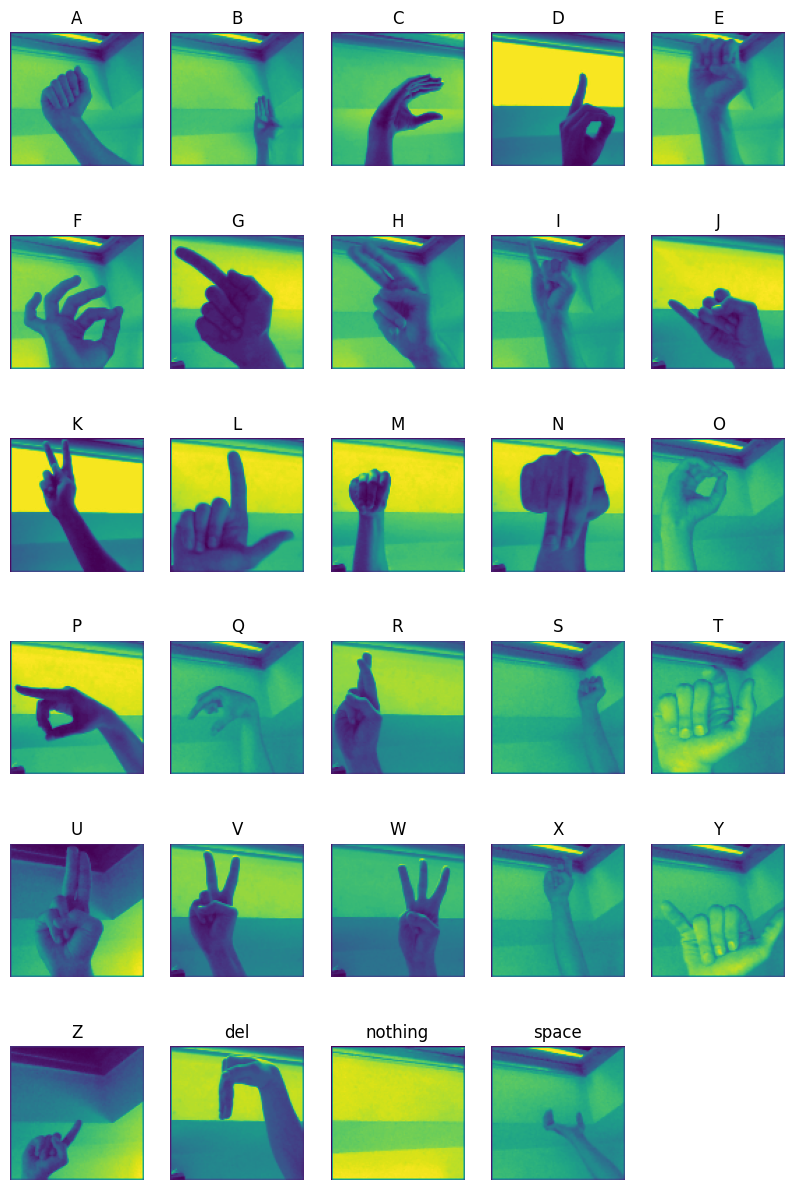

In [10]:
# Memvisualisasikan gambar untuk masing-masing kelas pada dataset latih
# Catatan: citra pada array dataset latih telah disortir menurut kelasnya

plt.figure(figsize=(10, 18))
for i in range(len(classes)):
    ax = plt.subplot(7, 5, i+1)
    im = train_images[(len(train_images) // 29) * i] # Agar terambil citra pertama dari setiap kelas yang ada
    plt.imshow(im)
    plt.title(classes[i])
    plt.axis('off')

## Pemrosesan Citra: _Image Enhancement_

In [38]:
import cv2 as cv
import numpy as np

# Fungsi untuk meningkatkan kualitas citra
def enhance(img):
    # Ekualisasi histogram untuk meningkatkan kontras
    img = cv.equalizeHist(img)

    # Median filter untuk menghilangkan noise
    img = cv.medianBlur(img, 3)

    # Bilateral filter untuk menghilangkan noise sambil mempertahankan tepi
    img = cv.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

    # Adaptive histogram equalization (CLAHE) untuk meningkatkan kontras lokal
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Sharpening untuk mempertegas detail
    kernel_sharpening = np.array([[0, -1, 0],
                                   [-1, 5, -1],
                                   [0, -1, 0]])
    img = cv.filter2D(img, -1, kernel_sharpening)

    return img


In [39]:
# Mengaplikasikan fungsi enhance() terhadap data citra

train_images_enhanced = [enhance(im) for im in train_images]
test_images_enhanced = [enhance(im) for im in test_images]


# Menghapus data citra mentah yang belum diolah dari memori, untuk menghemat penggunaan ruang pada memori

del train_images
del test_images
gc.collect()

13

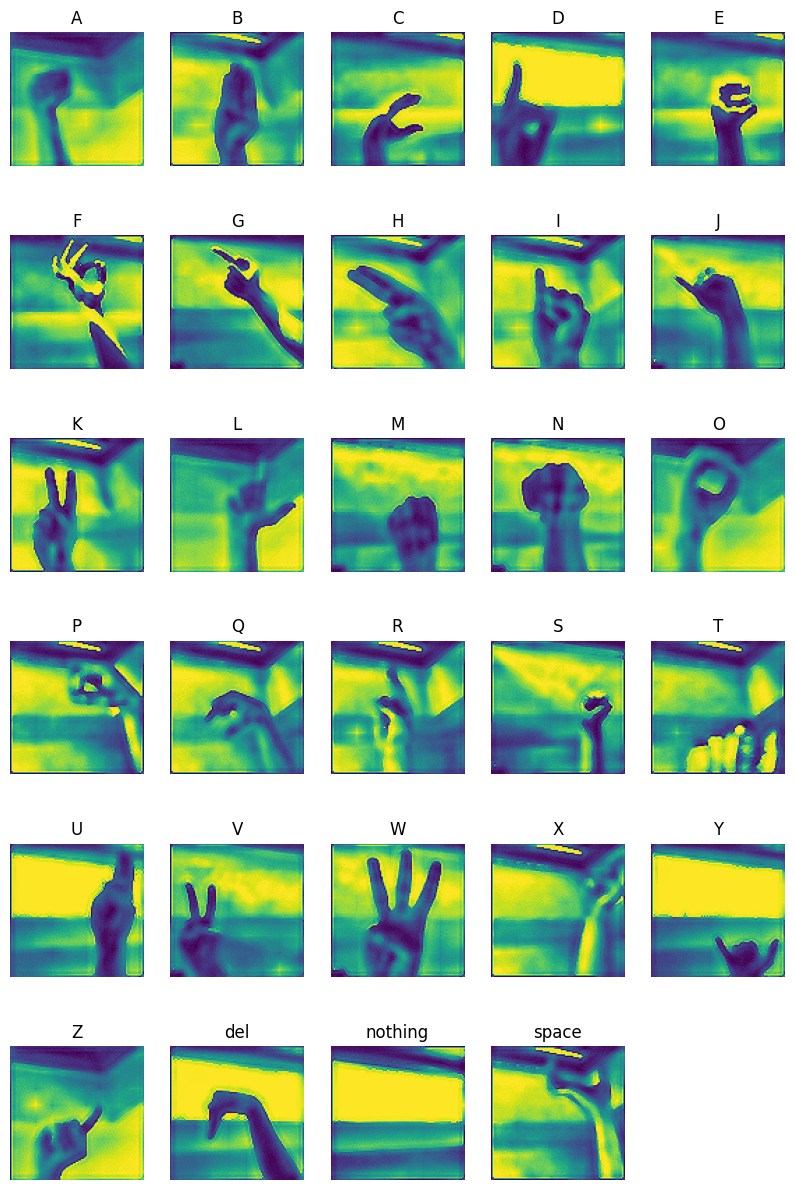

In [40]:
# Memvisualisasikan citra hasil pengolahan
# Catatan: citra pada array dataset latih telah disortir menurut kelasnya

plt.figure(figsize=(10, 18))
for i in range(len(classes)):
    ax = plt.subplot(7, 5, i+1)
    im = train_images_enhanced[(len(train_images_enhanced) // 29) * i] # Agar terambil citra pertama dari setiap kelas yang ada
    plt.imshow(im)
    plt.title(classes[i])
    plt.axis('off')

## Pemrosesan Citra: Ekstraksi Fitur

In [41]:
# Inisiasi ekstraksi ciri

orb = cv.ORB_create()

# Fungsi untuk mengekstrak deskriptor ciri (feature descriptor) dari sebuah citra
def get_featuredesc_ORB(im):
    # Pertama, mengambil keypoint dari citra
    kp = orb.detect(im, None)

    # Setelah itu, mendapatkan desciptor berdasarkan keypoint yang ada
    kp, des = orb.compute(im, kp)

    # Terdapat kemungkinan bahwa tidak ada keypoint maupun descriptor yang ditangkap, sehingga des dapat bernilai None.
    # Karena itu, agar fungsi tidak mengembalikan None, jika des bernilai None maka fungsi akan mengembalikan array berisi nol dengan
    # dimensi (1, 32)
    return des if des is not None else np.zeros((1,32))


# Fungsi yang mengembalikan visualisasi keypoint untuk fitur-fitur pada sebuah citra
def get_keypoint_vis_ORB(im):
    kp = orb.detect(im, None)

    # Visualisasi keypoint ke dalam citra menggunakan fungsi cv.drawKeypoints()
    # Sekali lagi, hal ini akan berlaku hanya jika keypoints terdeteksi dari citra
    return cv.drawKeypoints(im, kp, None, color=(0,255,0), flags=0) if kp is not None else im

In [42]:
# Mengaplikasikan fungsi untuk memperoleh feature descriptor dari setiap citra

train_features = [get_featuredesc_ORB(im) for im in train_images_enhanced]
test_features = [get_featuredesc_ORB(im) for im in test_images_enhanced]

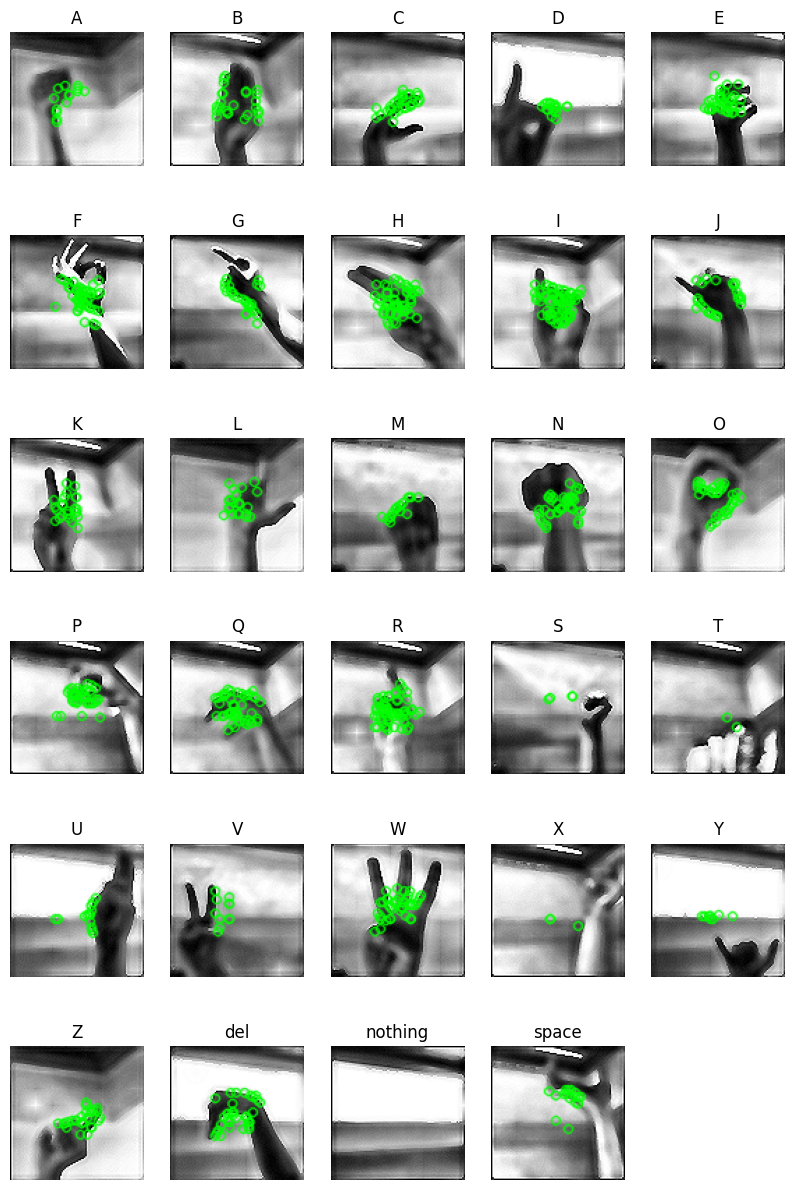

In [43]:
# Memvisualisasikan keypoint untuk setiap kelas
# Catatan: citra pada array dataset latih telah disortir menurut kelasnya

plt.figure(figsize=(10, 18))
for i in range(len(classes)):
    ax = plt.subplot(7, 5, i+1)
    im = train_images_enhanced[(len(train_images_enhanced) // 29) * i] # Agar terambil citra pertama dari setiap kelas yang ada
    im = get_keypoint_vis_ORB(im)
    plt.imshow(im)
    plt.title(classes[i])
    plt.axis('off')

In [17]:
# Menghapus data citra dari memori

del train_images_enhanced
del test_images_enhanced
gc.collect()

67098

In [18]:
# Membuat bag of features dengan klasterisasi menggunakan KMeans
from sklearn.cluster import KMeans

# Ukuran word pada bag of features. Banyaknya klaster akan mengikuti nilai ini.
WORDS = 200

# Menggabungkan feature descriptor pada dataset latih dan dataset uji untuk diklasterisasi dengan KMeans dalam rangka menghasilkan bag of features.
# Hal ini dapat dilakukan untuk mengurangi dimensi yang berlebih
kmeans = KMeans(n_clusters=WORDS, verbose=1).fit(np.concatenate([np.vstack(train_features), np.vstack(test_features)]))

Initialization complete
Iteration 0, inertia 122907507213.0.
Iteration 1, inertia 95209131757.84068.
Iteration 2, inertia 93119138163.72737.
Iteration 3, inertia 92264847146.27705.
Iteration 4, inertia 91782293009.44212.
Iteration 5, inertia 91464647498.61153.
Iteration 6, inertia 91237671091.75854.
Iteration 7, inertia 91067513707.1251.
Iteration 8, inertia 90934519588.56268.
Iteration 9, inertia 90826928531.94498.
Iteration 10, inertia 90737795265.58508.
Iteration 11, inertia 90663795363.14467.
Iteration 12, inertia 90602320877.09258.
Iteration 13, inertia 90550510600.03969.
Iteration 14, inertia 90506761251.51024.
Iteration 15, inertia 90469765682.59412.
Iteration 16, inertia 90438133762.50076.
Iteration 17, inertia 90411335281.15115.
Iteration 18, inertia 90388351114.33318.
Iteration 19, inertia 90368247171.03525.
Iteration 20, inertia 90350013456.57735.
Iteration 21, inertia 90332951848.84167.
Iteration 22, inertia 90316977693.44757.
Iteration 23, inertia 90301953244.13927.
Iterat

In [19]:

# Mendapatkan bag of features dari setiap citra
# Setiap fitur pada citra akan dikelompokkan ke dalam satu klaster, dengan model KMeans yang dilatih sebelumnya
# Selanjutnya, untuk setiap citra, banyaknya anggota masing-masing klaster akan dihitung
# Hal ini dilakukan untuk data latih dan data uji

X_train = np.stack([np.bincount(kmeans.predict(x), minlength=WORDS) for x in train_features])
X_test = np.stack([np.bincount(kmeans.predict(x), minlength=WORDS) for x in test_features])

In [20]:
# Menghapus data fitur dari memori
del train_features
del test_features
gc.collect()

0

## Klasifikasi dengan SVM

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [22]:
# Konversi data label menjadi NumPy Array

y_train = np.array(y_train)
y_test = np.array(y_test)

In [27]:
# Membuat dan melatih model-model SVM
# Terdapat tiga model SVM yang mengadaptasi kernel yang berbeda-beda

clf0 = SVC(kernel='rbf')
clf1 = SVC(kernel='poly')
clf2 = SVC(kernel='linear')

clf0.fit(X_train, y_train)
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)

SVC(kernel='linear')

In [28]:
# Melakukan prediksi kelas untuk data uji

y_pred0 = clf0.predict(X_test)
y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)

In [26]:
# Menampilkan nilai akurasi model

print(f'Akurasi model 0 (rbf kernel): {accuracy_score(y_test, y_pred0)}')
print(f'Akurasi model 1 (poly kernel): {accuracy_score(y_test, y_pred1)}')
print(f'Akurasi model 2 (linear kernel): {accuracy_score(y_test, y_pred2)}')

NameError: name 'y_pred0' is not defined

In [ ]:
# Menampilkan laporan hasil klasifikasi

print('Classification report - Model 0 (rbf kernel):')
print(classification_report(y_test, y_pred0))

In [ ]:
print('Classification report - Model 1 (poly kernel):')
print(classification_report(y_test, y_pred1))

In [ ]:
print('Classification report - Model 2 (linear kernel):')
print(classification_report(y_test, y_pred2))

In [ ]:
# Visualisasi Confusion Matrix

plt.figure(figsize=(25, 12))
plt.title('Confusion Matrix - Model 0 (rbf kernel)')
sns.heatmap(confusion_matrix(y_test, y_pred0), annot=True, fmt="d")

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Confusion Matrix - Model 1 (poly kernel)')
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt="d")

In [ ]:
plt.figure(figsize=(25, 12))
plt.title('Confusion Matrix - Model 2 (linear kernel)')
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt="d")

Accuracy: 0.25448275862068964

Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.20      0.18       600
           1       0.08      0.47      0.14       600
           2       0.24      0.45      0.31       600
           3       0.30      0.54      0.39       600
           4       0.42      0.08      0.14       600
           5       0.29      0.46      0.35       600
           6       0.34      0.13      0.19       600
           7       0.31      0.37      0.34       600
           8       0.23      0.18      0.20       600
           9       0.47      0.19      0.27       600
          10       0.42      0.33      0.37       600
          11       0.24      0.49      0.33       600
          12       0.31      0.21      0.25       600
          13       0.19      0.15      0.17       600
          14       0.42      0.23      0.30       600
          15       0.44      0.22      0.30       600
          16       0.41   

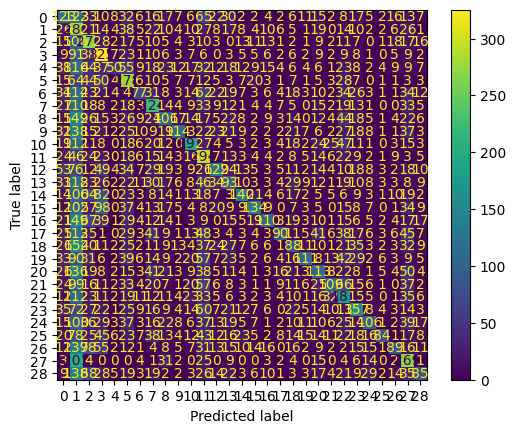

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Pastikan X_train, X_test sudah berupa array atau matriks sebelumnya
# Jika belum, tambahkan konversi sesuai kebutuhan:
# X_train = np.array(X_train)
# X_test = np.array(X_test)

# Konversi data label
y_train = np.array(y_train)
y_test = np.array(y_test)

# Inisialisasi Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Training
rfc.fit(X_train, y_train)

# Prediksi
y_pred = rfc.predict(X_test)

# Evaluasi Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()
